In [357]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from utils import wavelength_to_rgb

In [358]:
# measurements
dist = {
    '4p2s-': 0.9,
    '4d2p+': 1.7,
    '3p2s-': 2.5,
    '3d2p+': 3.7,
    '3s2p+': 4.9
}
real = {
    '4p2s-': 396.5,
    '4d2p+': 447.1,
    '3p2s-': 501.6,
    '3d2p+': 587.9,
    '3s2p+': 706.9
}
keys = list(dist.keys())
for key in keys:
    dist[key] = np.array(dist[key])
    
ddist = 0.1
L = 34.5
dL = 0.5
N0 = 600
dN0 = 69

ni = dict()
nf = dict()
parity = dict()
labels = dict()
for key in keys:
    ni[key] = int(key[0])
    nf[key] = int(key[2])
    parity[key] = int(key[4]=='+')
    labels[key] = '$' + key[0:2] + '\\to' + key[2:4] + '^' + key[4] + '$'


In [359]:
# fit N to derive wavelengths
lamb = dict()
dlamb = dict()

# lamodel = lambda d, N, o: np.sin(np.arctan(d/L))/N * 1e7 + o
lamodel = lambda d, N, o: d/L/N * 1e7 + o
distlist = np.array([dist[key] for key in keys])
reallist = np.array([real[key] for key in keys])
[N, o], cov = sp.optimize.curve_fit(
    lamodel, distlist, reallist,
    p0=[N0, 300]
)

lares = lamodel(distlist, N, o) - reallist
lachi2 = np.sum((lares/(0.05/distlist)/reallist)**2)
larchi2 = lachi2 / (reallist.size - 1)

for key in keys:
    lamb[key] = lamodel(np.array([dist[key]]), N, o)[0]
    dlamb[key] = lamb[key] * 0.05/dist[key]

{'N': N, 'dN': dN, 'o': o,'fit rms residual': np.sqrt(np.mean(lares**2)), 'reduced chi 2': larchi2}

{'N': 3775.3290925246088,
 'dN': 172.96477416283355,
 'o': 317.6334653473788,
 'fit rms residual': 10.21118120096728,
 'reduced chi 2': 1.7835519155031445}

In [360]:
h = 1240 # eV nm

(1.0, 0.0)

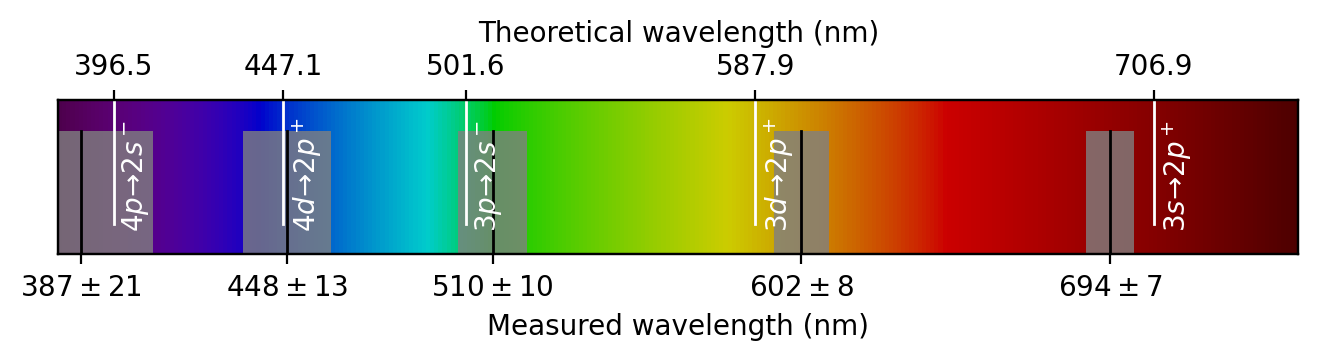

In [361]:
fig, ax = plt.subplots(figsize=(8, 1), dpi=200)
lmin = 380
lmax = 750
space = np.linspace(lmax, lmin, 300)
plt.xlabel('Measured wavelength (nm)')
ax.set_xlim(lmin, lmax)

for key in keys:
    plt.axvspan(lamb[key] - dlamb[key], lamb[key] + dlamb[key], facecolor='gray', alpha=0.8, ymax=0.8)
    plt.axvline(lamb[key], color='black', lw=1, ymax=0.8)
    plt.axvline(real[key], color='white', lw=1, ymin=0.2)
    plt.text(real[key]+2, 0.8, labels[key], color='white', rotation=90)

ax.set_xticks([lamb[key] for key in keys], labels=[f'${lamb[key]:.0f} \pm {dlamb[key]:.0f}$' for key in keys])
ax.set_yticks([])
ax.set_ylim(0, 1)
ax.imshow([wavelength_to_rgb(space)*0.8], extent=[np.max(space), np.min(space), 0, 1], aspect='auto')

fax = ax.twiny()
fax.set_xlim(lmin, lmax)
fax.set_xticks([real[key] for key in keys], labels=[f'{real[key]:.1f}' for key in keys])
fax.set_xlabel('Theoretical wavelength (nm)')
fax.set_ylim(1,0)

In [362]:
lam = np.array(list(lamb.values()))
dlam = np.array(list(dlamb.values()))
p = np.array(list(parity.values()))
ll = 1/lam * 1e3
dll = (dlam/lam/lam) * 1e3
nn = np.array(list(nf.values()))**(-2.0) - np.array(list(ni.values()))**(-2.0)
np.max(nn), np.min(nn)

(0.1875, 0.1388888888888889)

In [363]:
model = lambda nn, Ry: Ry*nn/1.24
[Ry], [[dRy]] = sp.optimize.curve_fit(
    model, nn, ll, 
    p0=[13.6], sigma=dll
)
dRy = np.sqrt(dRy)
Ry, dRy

(13.910501285237688, 0.7264693793821596)

In [364]:
Zeff = np.sqrt(Ry/13.6)
dZeff = 0.5 * dRy / np.sqrt(Ry)
Zeff, dZeff

(1.0113510650885342, 0.09739035020866561)

In [365]:
res = ll - model(nn, Ry)
err = (model(nn, Ry+dRy) - model(nn, Ry-dRy))
normres = res / err
chi2 = np.sum(normres*normres)
rchi2 = chi2/2
rchi2

6.127980873270342

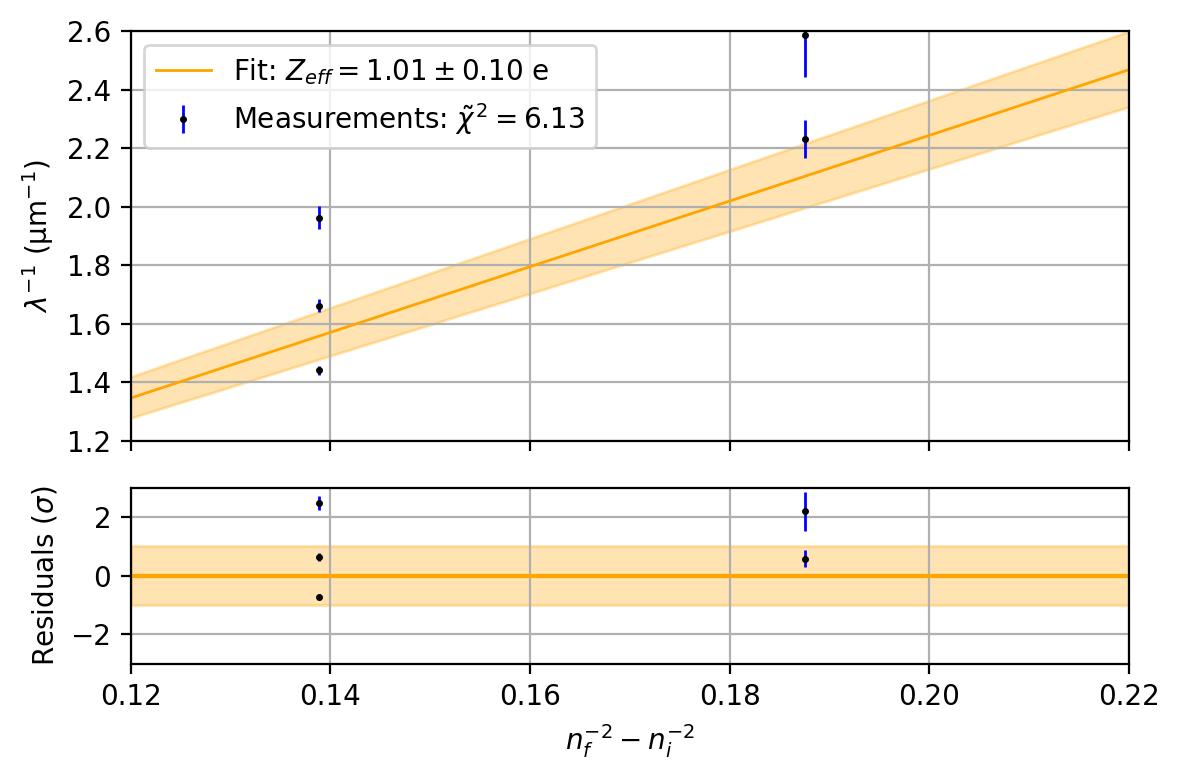

In [367]:
fig, (ax, ax_res) = plt.subplots(
    2, 1, sharex=True, 
    figsize=(6, 4), dpi=200, 
    gridspec_kw={'height_ratios': [7, 3]}
)

plt.sca(ax)

space = np.linspace(0.1, 0.3)
# plt.plot(space, model(space, 13.6), color='green', lw=1,
#             label=f'Theory: $E_0 = 13.6$ eV', ls=':'
# )

plt.plot(space, model(space, Ry), color='orange', lw=1,
            label=f'Fit: $Z_{{eff}} = {Zeff:.2f} \pm {dZeff:.2f}$ e'
)
plt.fill_between(space, model(space, Ry-dRy), model(space, Ry+dRy), color='orange', alpha=0.3)
plt.errorbar(
    nn, ll, yerr = dll,
    ecolor="blue", color='black', 
    linewidth = 0, elinewidth = 1, markersize = 3, marker='.',
    label=f'Measurements: $\\tilde\chi^2 = {rchi2:.2f}$'
)

plt.ylabel('$\lambda^{-1}$ (μm$^{-1}$)')
plt.xlim(0.12, 0.22)
plt.ylim(1.2, 2.6)
plt.legend(loc='upper left')
plt.grid()

plt.sca(ax_res)
plt.errorbar(
    nn, res/err, yerr = dll/err,
    ecolor="blue", color='black', 
    linewidth = 0, elinewidth = 1, markersize = 3, marker='.'
)
plt.ylim(-3, 3)
plt.axhspan(-1, 1, color='orange', alpha=0.3)
plt.axhline(0, color='orange')
errspace = (model(space, Ry+dRy) - model(space, Ry-dRy))/2
# plt.plot((model(space, 13.6)-model(space, Ry))/errspace, color='green', ls=':')
plt.xlabel('$n_f^{-2} - n_i^{-2}$')
plt.ylabel('Residuals ($\sigma$)')
plt.grid()

plt.tight_layout()